# Sprawozdanie 2 z Uczenia maszynowego

### Jakub Zdanowski XXXXXX, Błażej Latos XXXXXX
##### Zajęcia w czwartek, 16:50.
#### Udział autorów:
- JZ wykonał rozdziały: 1, 2 oraz 2.1
- BL wykonał ....

*Oświadczam/y, że niniejsze sprawozdanie zostało przygotowane wyłącznie przez powyższych
autora/ów, a wszystkie elementy pochodzące z innych źródeł zostały odpowiednio zaznaczone
i są cytowane w bibliografii.*

## 1. Zbiór danych

Postanowiliśmy użyć zbioru danych, który jest dość popularny i dobrze nadaje się do tego projektu. [Dane](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) opierają się na danych spisowych ludności z Kalifornii z 1990 roku.

Poniżej zostaną przedstawione podstawowe informacje takie jak liczba przykładów, średnia, odchylenie standardowe, max, min i różne kwantyle.

In [1]:
import pandas as pd
pd.options.display.precision = 2

# wczytanie danych z pliku .csv
california_housing_dataframe = pd.read_csv("california_housing_train.csv")

# ilustracja podstawowych informacji o danych
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207300.91
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115983.76
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119400.00
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180400.00
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265000.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500001.00


In [2]:
# poniższa funkcja pokazuje 5 pierwszych wierszy w danych 
# dla zilustrowania typu i przykładowych wartości danych
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.49,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.82,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.65,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.19,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.93,65500.0


### Co zawierają dane?
Wszystkie dane są typu *float64*.

Powyższa tabela ukazuje podstawowe (liczbowe) informacje o danych, poniżej krótki opis kazdej z kolumn:
- **longitude** - szerokość geograficzna
- **latitude** - długość geograficzna
- **housing_median_age** - średni wiek domu
- **total_rooms** - całkowita liczba pokoi w bloku
- **total_bedrooms** - całkowita liczba sypialni w bloku
- **population** - całkowita liczba osób mieszkających w bloku
- **households** - łączna liczba gospodarstw domowych (grupa osób mieszkających w jednostce domowej) na blok
- **median_income** - mediana dochodu dla gospodarstwa domowego w bloku (mierzona w dziesiątkach tysięcy dolarów amerykańskich)
- **median_house_value** - mediana wartości domu dla gospodarstw domowych w bloku (mierzona w dolarach amerykańskich)

### 1.1 Wstępna analiza danych
TODO

## 2. Predykcja wartości domu

Głownym zadaniem w omawianym problemie jest predykcja wartości domu na podstawie wszelakich cech. Zakładamy że lokalizacja i wiek budynku będą miały znaczny wpływ na cenę mieszkania oraz, że cena będzie większa dla mieszkań z większa liczbą sypialni i pokoi w budynku. 

In [3]:
# załadowanie podstawowych bibliotek
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Dane zostaną przemieszane, aby mieć pewność, że nie pojawią się żadne patologiczne efekty porządkowania, które mogłyby zaszkodzić wydajności SGD. Dodatkowo, zmieniona zostanie wartość `median_house_value` na jednostki tysiąca, aby można było się jej nauczyć nieco łatwiej przy współczynnikach uczenia w niskim zakresie.

In [4]:
# przemieszanie kolejności danych
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

# zmniejszenie zakresu wartości mieszkań
california_housing_dataframe["median_house_value"] /= 1000.0

### 2.1 Regresja liniowa
Do predykcji wartości domu zostanie użyta regresja liniowa na pojedynczych cechach. Wybierzemy kilka z nich dla porównania i dla uzyskania informacji jakie cechy maja duży związek z badaną wartością domu.

Użyty został estymator regresji liniowej wraz z metodą spadku gradientu do optymalizacji. W ten sposób zostały przetestowane sposoby parametryzacji hyperparametrów takich jak wielkość paczek (batch), współczynnika uczenia oraz liczby iteracji. 

#### Definicja cech i predykcji

In [5]:
# wybór kolumn do predykcji wartości mieszkania
X_feature = california_housing_dataframe[["total_rooms"]]

# opis danych funkcji; nie zawierają samych danych
X_column = [tf.feature_column.numeric_column("total_rooms")]

In [6]:
# definicja predykcji
y_target = california_housing_dataframe["median_house_value"]

#### Przygotowanie *LinearRegressor*

In [7]:
# użycie spadku gradientu do optymalizacji 
linear_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)

# Powszechnie stosowany mechanizm zmniejszania problemu gradientu eksplodującego
# poprzez sztuczne ograniczanie (przycinanie) maksymalnej wartości gradientów
linear_optimizer = tf.contrib.estimator.clip_gradients_by_norm(linear_optimizer, 5.0)

# konfiguracja regresora liniowego wraz z wybranymi kolumnami
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = X_column,
    optimizer = linear_optimizer
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Przygotowanie funkcji wejściowej

`input_func` funkcja pozwalająca na użycie danych wczytanych przez *pandas* w estymatorach *tensorflow*. Napisana na podstawie [przewodnika tensorflow](https://www.tensorflow.org/guide/datasets).

In [8]:
# funckja użyta będzie w kolejnych zadaniach
def input_func(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # konwertowanie do tablic numpy'owych
    features = {key:np.array(value) for key, value in dict(features).items()} 
    
    # przy większych danych należy zwrócić uwagę czy zmieszczą się w pamięci
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    # zwrócenie kolejnej paczki (batch) danych
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels    

#### Wytrenowanie modelu

In [9]:
_ = linear_regressor.train(
    input_fn = lambda:input_func(X_feature, y_target),
    steps=500
)

In [10]:
# fukcja wejściowa do predykcji
prediction_input_fn = lambda: input_func(X_feature, y_target, num_epochs=1, shuffle=False)

# wywołanie predykcji
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# wyciągnięcie informacji jako tablica NumPy
predictions = np.array([item['predictions'][0] for item in predictions])

# Wypisanie podstawowych metryk
mean_squared_error = metrics.mean_squared_error(predictions, y_target)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Średni błąd kwadratowy (MSE): %0.3f" % mean_squared_error)
print("Pierwiastek błędu średniokwadratowego (RMSE) : %0.3f" % root_mean_squared_error)

Średni błąd kwadratowy (MSE): 56135.268
Pierwiastek błędu średniokwadratowego (RMSE) : 236.929


Łatwo zauważyć że błąd ten jest bardzo duży. Należało by dostroić parametry oraz użyć większej liczby iteracji na trenowanie modelu. Stąd w pliku `helpers.py` zaimplementowana funkcja która łączy powyższe metody w jedną oraz pozwala na dostrojenie parametrów oraz testowanie pozostałych cech. Analiza zostanie przeprowadzona poniżej.

#### Sprawdzenie pozostałych cech
Przetestowane zostały wszystkie cechy oprócz długości i szerokości geogrficznej. Zakładamy, że sama wielkość tych wartości nie ma wspływu na cenę mieszkań, tylko niektóre wartości odpowiadające większym miastom mają wpływ na cenę. Funkcja `train_models` przyjmuje kilka parametrów. Są to dane, współczynnik uczenia, liczba iteracji na epokę wielkość paczki na jedną iterację oraz nazwa kolumny.

Trenowanie modelu housing_median_age
RMSE w kolejnych epokach):
  epoka 00 : 212.67
  epoka 01 : 189.71
  epoka 02 : 169.78
  epoka 03 : 154.09
  epoka 04 : 145.28
  epoka 05 : 140.56
  epoka 06 : 137.72
  epoka 07 : 136.80
  epoka 08 : 136.16
  epoka 09 : 136.01
Zakończono housing_median_age


,predictions,targets
count,17000.0,17000.0
mean,174.3,207.3
std,76.5,116.0
min,6.6,15.0
25%,110.0,119.4
50%,176.8,180.4
75%,225.5,265.0
max,316.7,500.0


Końcowe RMSE: 136.01
KONIEC dla housing_median_age
*****************************************************

Trenowanie modelu total_rooms
RMSE w kolejnych epokach):
  epoka 00 : 222.75
  epoka 01 : 209.12
  epoka 02 : 197.10
  epoka 03 : 187.27
  epoka 04 : 179.07
  epoka 05 : 173.21
  epoka 06 : 169.22
  epoka 07 : 167.33
  epoka 08 : 166.51
  epoka 09 : 166.32
Zakończono total_rooms


,predictions,targets
count,17000.0,17000.0
mean,131.9,207.3
std,108.7,116.0
min,0.1,15.0
25%,72.9,119.4
50%,106.1,180.4
75%,157.2,265.0
max,1892.1,500.0


Końcowe RMSE: 166.32
KONIEC dla total_rooms
*****************************************************

Trenowanie modelu total_bedrooms
RMSE w kolejnych epokach):
  epoka 00 : 222.50
  epoka 01 : 209.01
  epoka 02 : 196.79
  epoka 03 : 187.19
  epoka 04 : 179.56
  epoka 05 : 174.23
  epoka 06 : 171.22
  epoka 07 : 169.78
  epoka 08 : 169.31
  epoka 09 : 169.68
Zakończono total_bedrooms


,predictions,targets
count,17000.0,17000.0
mean,140.2,207.3
std,109.5,116.0
min,0.3,15.0
25%,77.2,119.4
50%,112.8,180.4
75%,168.4,265.0
max,1674.7,500.0


Końcowe RMSE: 169.68
KONIEC dla total_bedrooms
*****************************************************

Trenowanie modelu population
RMSE w kolejnych epokach):
  epoka 00 : 225.63
  epoka 01 : 214.84
  epoka 02 : 204.86
  epoka 03 : 196.59
  epoka 04 : 190.21
  epoka 05 : 184.79
  epoka 06 : 180.84
  epoka 07 : 178.13
  epoka 08 : 176.92
  epoka 09 : 176.04
Zakończono population


,predictions,targets
count,17000.0,17000.0
mean,119.2,207.3
std,95.7,116.0
min,0.3,15.0
25%,65.9,119.4
50%,97.3,180.4
75%,143.5,265.0
max,2975.9,500.0


Końcowe RMSE: 176.04
KONIEC dla population
*****************************************************

Trenowanie modelu households
RMSE w kolejnych epokach):
  epoka 00 : 223.42
  epoka 01 : 210.36
  epoka 02 : 198.79
  epoka 03 : 189.43
  epoka 04 : 181.31
  epoka 05 : 175.22
  epoka 06 : 171.37
  epoka 07 : 169.13
  epoka 08 : 167.43
  epoka 09 : 167.14
Zakończono households


,predictions,targets
count,17000.0,17000.0
mean,133.3,207.3
std,102.2,116.0
min,0.3,15.0
25%,75.0,119.4
50%,108.7,180.4
75%,160.9,265.0
max,1617.0,500.0


Końcowe RMSE: 167.14
KONIEC dla households
*****************************************************

Trenowanie modelu median_income
RMSE w kolejnych epokach):
  epoka 00 : 206.97
  epoka 01 : 177.32
  epoka 02 : 149.15
  epoka 03 : 123.43
  epoka 04 : 102.97
  epoka 05 : 91.71
  epoka 06 : 86.73
  epoka 07 : 85.35
  epoka 08 : 85.78
  epoka 09 : 84.99
Zakończono median_income


,predictions,targets
count,17000.0,17000.0
mean,196.5,207.3
std,90.0,116.0
min,37.0,15.0
25%,134.4,119.4
50%,180.5,180.4
75%,238.2,265.0
max,720.8,500.0


Końcowe RMSE: 84.99
KONIEC dla median_income
*****************************************************



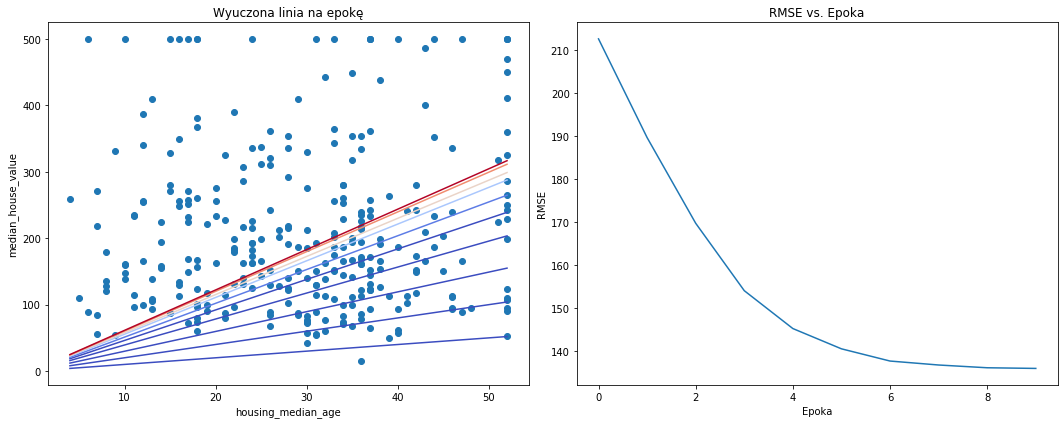

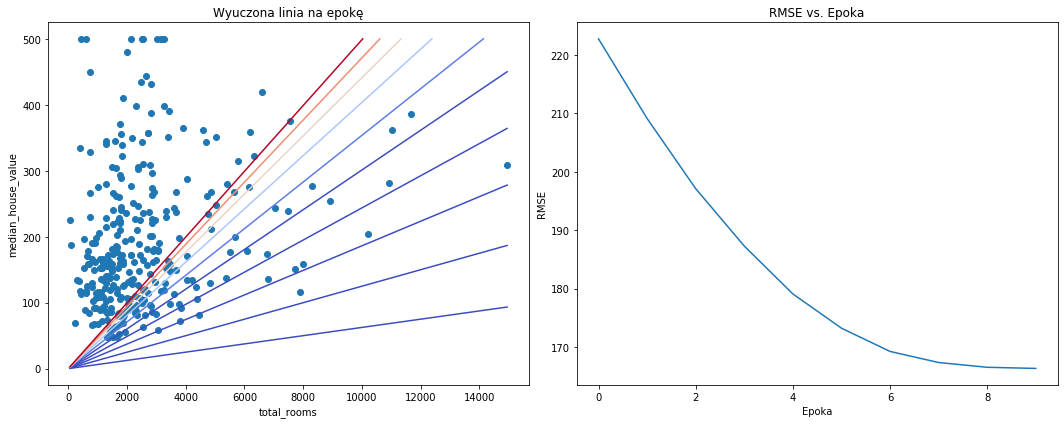

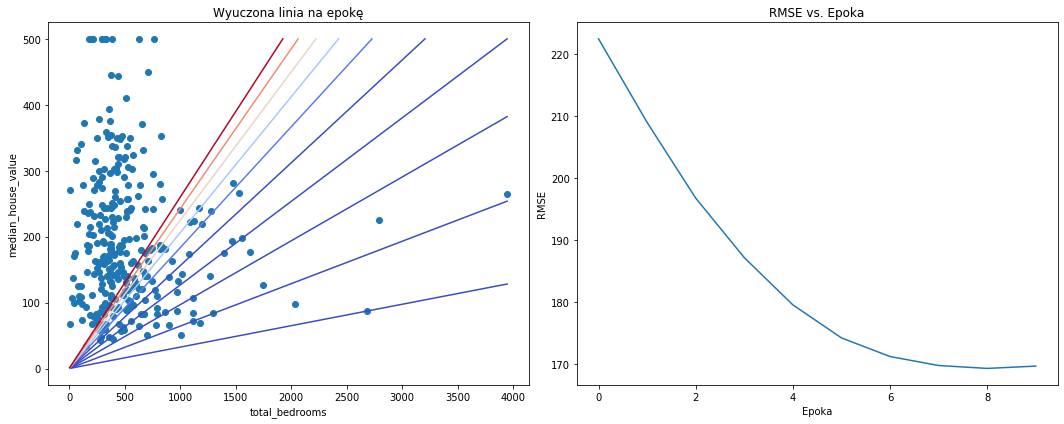

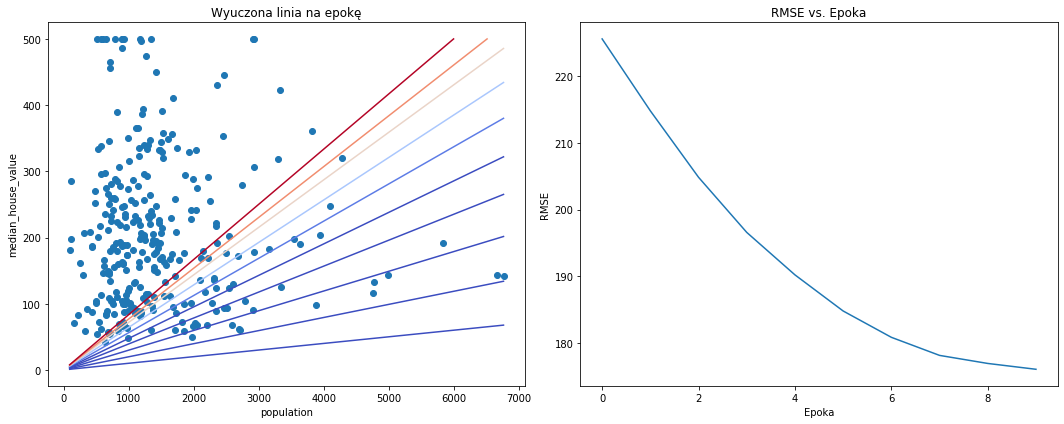

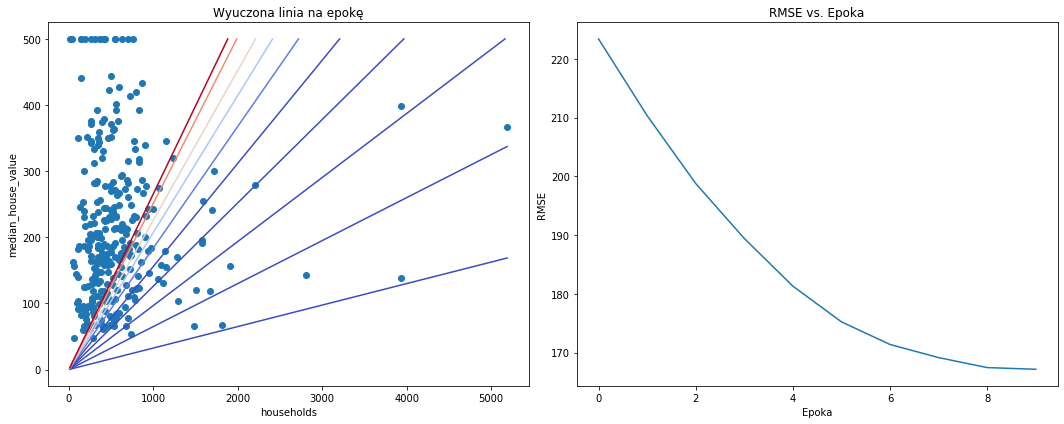

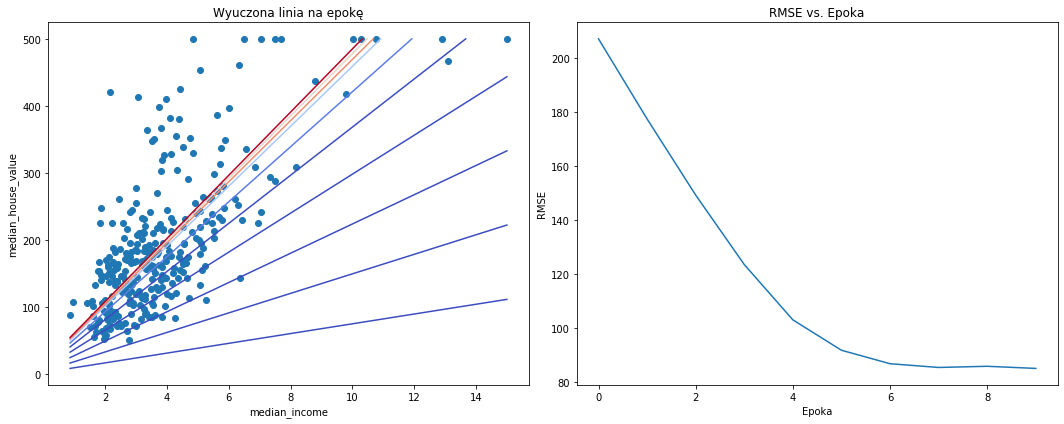

In [11]:
from helpers import train_models
# sprawdzenie pozostałych cech
features = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
# ustawnienie hyperparametru na podstawie testów
learning_rates = [0.002, 0.0000125, 0.000065, 0.00002, 0.000065, 0.015]

for feature, learning_rate in zip(features, learning_rates):
    train_models(
        california_housing_dataframe=california_housing_dataframe,
        learning_rate=learning_rate,
        steps=1000,
        batch_size=5,
        input_feature=feature
    )

Dla każdej z cech należało ustawić odpowiedni współczynnik uczenia. Z powodu ograniczeń czasowych ustawiono stosunkowo małą liczbę paczek (batch) oraz iteracji w epoce. Jednak ustawienia te dały opdpowiednią wizualizację graficzną jak i liczbową w jaki wpływ cechy mają wpływ na wartość wyjściową. 

Najmniejszy RMSE (~85) uzyskała cecha *median_income* - co nie jest zaskoczeniem. Ludzie bardziej zamożni mieszkają w droższych mieszkaniach. Dobry rezultat uzyskała także cecha housing_median_age (~136) co także ma odpowiedź w rzeczywistości - czym starszy blok mieszkalny tym cena mieszkań w tym bloku będzie mniejsza. Pozostałe cechy osiągnęły bład na poziomie ~160~180.

Należy także zwrócić uwagę na wpływ wartości odstających, są one zauważalne na wykresach. Możemy spekulować, że wynikają one z pomyłek lub ustawiania wartości domyślnej przy braku jakiś danych. Na tą chwilę te wartości nie zostały usunięte, głównym celem było zauważenie podstawowych związków między cechami a wartościami cen mieszkań oraz zapoznanie się ze spadkiem gradientu użytym w tego typu problemie.